In [ ]:
import os
import pickle

#Calculate distance matrix

import geopandas as gpd
import pandas as pd
import numpy as np

def calculate_centroid_distance_matrix(
    adm1_gdf_input: gpd.GeoDataFrame,
    target_country_name: str,
    target_projected_crs: str, # e.g., "EPSG:32630" for Burkina Faso, "EPSG:32736" for Tanzania (UTM Zone 36S)
    adm0_col: str = 'COUNTRY',
    adm1_col: str = 'NAME_1'
) -> pd.DataFrame:
    """
    Calculates a matrix of Euclidean distances between the centroids of
    admin1 regions for a specific country.

    Args:
        adm1_gdf_input (gpd.GeoDataFrame): Input GeoDataFrame with admin boundaries.
                                         Must contain admin level 0 and 1 names and geometry.
        target_country_name (str): The name of the country to process.
        target_projected_crs (str): EPSG code for a projected CRS suitable for
                                    distance calculations in the target country.
                                    Distances will be in the units of this CRS (typically meters).
        adm0_col (str): Column name for admin level 0 (country).
        adm1_col (str): Column name for admin level 1 (region).

    Returns:
        pd.DataFrame: A square DataFrame where index and columns are ADM1_NAMEs
                      and values are distances (in CRS units, typically meters).
                      Returns an empty DataFrame if the country is not found or has < 1 region.
    """
    # Filter for the target country
    country_gdf = adm1_gdf_input[adm1_gdf_input[adm0_col] == target_country_name].copy()

    if country_gdf.empty:
        print(f"No data found for country: {target_country_name}")
        return pd.DataFrame()

    # Reproject to the target projected CRS for accurate distance calculation
    try:
        country_gdf_projected = country_gdf.to_crs(target_projected_crs)
    except Exception as e:
        print(f"Error reprojecting to {target_projected_crs} for {target_country_name}: {e}")
        print("Please ensure a valid projected CRS is provided for distance calculations.")
        return pd.DataFrame()

    # Ensure geometries are valid before calculating centroids
    country_gdf_projected['geometry'] = country_gdf_projected.geometry.buffer(0)
    if not country_gdf_projected.geometry.is_valid.all():
        invalid_geoms = country_gdf_projected[~country_gdf_projected.geometry.is_valid][adm1_col].tolist()
        print(f"Warning: Some geometries in {target_country_name} are invalid even after buffer(0): {invalid_geoms}. Centroid calculation might be affected.")
    
    country_gdf_projected['centroid'] = country_gdf_projected.geometry.centroid

    admin_names = sorted(country_gdf_projected[adm1_col].unique())
    num_regions = len(admin_names)

    if num_regions < 1:
        print(f"No admin1 regions found for {target_country_name} to create a distance matrix.")
        return pd.DataFrame(index=admin_names, columns=admin_names)

    distance_matrix = pd.DataFrame(index=admin_names, columns=admin_names, dtype=float)

    # Create a map from unique admin names to their centroids
    # This handles cases where an admin name might appear multiple times if geometries are split
    unique_regions_gdf = country_gdf_projected.drop_duplicates(subset=[adm1_col], keep='first')
    centroids_map = pd.Series(unique_regions_gdf['centroid'].values, index=unique_regions_gdf[adm1_col]).to_dict()


    for i in range(num_regions):
        for j in range(num_regions):
            name_i = admin_names[i]
            name_j = admin_names[j]

            if i == j:
                distance_matrix.loc[name_i, name_j] = 0.0
                continue

            centroid_i = centroids_map.get(name_i)
            centroid_j = centroids_map.get(name_j)
            
            if centroid_i is None or centroid_j is None :
                 print(f"Warning: Centroid not found for {name_i} or {name_j} in centroids_map. Setting distance to NaN.")
                 distance_matrix.loc[name_i, name_j] = np.nan
                 continue

            if not centroid_i.is_valid or not centroid_j.is_valid:
                # This check might be redundant if centroids from .centroid are always valid, but good for safety
                print(f"Warning: Invalid centroid for {name_i} (valid: {centroid_i.is_valid}) or {name_j} (valid: {centroid_j.is_valid}). Setting distance to NaN.")
                distance_matrix.loc[name_i, name_j] = np.nan
                continue
                
            try:
                distance = centroid_i.distance(centroid_j) # Distance in CRS units (meters if UTM)
                distance_matrix.loc[name_i, name_j] = distance
            except Exception as e:
                print(f"Error calculating distance between {name_i} and {name_j}: {e}")
                distance_matrix.loc[name_i, name_j] = np.nan


    return distance_matrix

# --- How to convert distance matrix to travel time matrix (example) ---
# average_speed_kmh = 50.0 # Assume an average travel speed of 50 km/h

# # Assuming 'distance_matrix_meters' is the output from calculate_centroid_distance_matrix
# # and its units are meters (common for UTM projections)
# distance_matrix_km = distance_matrix_meters / 1000.0
# travel_time_matrix_hours = distance_matrix_km / average_speed_kmh

# # This 'travel_time_matrix_hours' can then be used as 'travel_time_matrix_df'
# # in the 'get_pop_weighted_avg_travel_time_from_origin' function from the previous response.


# --- Example Usage (using adm1_gdf from your notebook cell 9b2611c7) ---
# # Ensure adm1_gdf is loaded as in your notebook (cell id: 9b2611c7)
# # For example:
# # adm1_shapefile_path =  r'''C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\2DSUM-Gridded\Boundaries_admin_level_1\afr_g2014_2013_1_update.shp'''
# # adm1_gdf = gpd.read_file(adm1_shapefile_path) # Simplified loading for example

# For Burkina Faso, UTM Zone 30N (EPSG:32630) or 31N (EPSG:32631) are appropriate.
# Cell 9edd068e in your notebook uses EPSG:32630.

if 'adm1_gdf' in globals():
    print(f"\nCalculating distance matrix for {target_nation_sim}...")
    distance_matrix_m_adm2 = calculate_centroid_distance_matrix(
        adm1_gdf_input=adm1_gdf, # Make sure adm1_gdf is loaded
        target_country_name=target_nation_sim,
        target_projected_crs="EPSG:32630"
    )
else:
    print("\n'adm1_gdf' not found in global scope. Please load it first to run the example.")


sim_results_folder = r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\2DSUM-Gridded\SimResults"
adm2_gdf_path = os.path.join(sim_results_folder, "adm2_gdf.pkl")

# Create the directory if it doesn't exist
os.makedirs(sim_results_folder, exist_ok=True)

# Check if adm1_gdf file already exists
if os.path.exists(adm2_gdf_path):
    print(f"Loading existing adm2_gdf from {adm2_gdf_path}")
    with open(adm2_gdf_path, 'rb') as f:
        adm2_gdf = pickle.load(f)
    print(f"Loaded adm2_gdf with {len(adm2_gdf)} rows")

    def update_canonical_cereals(target_cereals):
    non_canonical_cereals = [cereal for cereal in target_cereals if cereal not in CANONICAL_CEREALS]
    canonical_to_original_mapping = {}

    if non_canonical_cereals:
        print(f"Non-canonical cereals found: {non_canonical_cereals}")
        print("Creating 'Cereals, Other' category by aggregating these cereals...")
        
        # Load hvstat_data if not already loaded
        hvstat_data = pd.read_csv(r"C:\Users\danie\Downloads\hvstat_africa_data_v1.0.csv")
        
        # Filter hvstat_data for the target nation and non-canonical cereals
        other_cereals_data = hvstat_data[
            (hvstat_data['country'] == target_nation_sim) & 
            (hvstat_data['product'].isin(non_canonical_cereals))
        ]
        print(target_nation_sim)
        
        if not other_cereals_data.empty:
            # Aggregate by summing production values for each harvest_year and admin1_name
            cereals_other_aggregated = other_cereals_data.groupby(['harvest_year', 'admin_2']).agg({
                'production': 'sum',
                'yield': 'mean',  # Take mean yield
                'area': 'sum'
            }).reset_index()
            
            # Add required columns
            cereals_other_aggregated['country'] = target_nation_sim
            cereals_other_aggregated['product'] = 'Cereals, Other'
            
            # Remove the non-canonical cereals from hvstat_data for this country
            hvstat_data_filtered = hvstat_data[
                ~((hvstat_data['country'] == target_nation_sim) & 
                (hvstat_data['product'].isin(non_canonical_cereals)))
            ]
            
            # Add the aggregated "Cereals, Other" data back
            hvstat_data = pd.concat([hvstat_data_filtered, cereals_other_aggregated], ignore_index=True)
            
            print(f"Successfully created 'Cereals, Other' category with {len(cereals_other_aggregated)} records")
            print(f"Removed {len(non_canonical_cereals)} non-canonical cereal products: {non_canonical_cereals}")
            
            # Create mapping from canonical to original cereals
            canonical_to_original_mapping['Cereals, Other'] = non_canonical_cereals
        else:
            print("No data found for non-canonical cereals in hvstat_data")
    else:
        print("All target cereals are canonical - no aggregation needed")
        # Load hvstat_data normally
        hvstat_data = pd.read_csv(r"C:\Users\danie\Downloads\hvstat_africa_data_v1.0.csv")
    
    # Create mappings for canonical cereals (1:1 mapping)
    canonical_cereals_in_target = [cereal for cereal in target_cereals if cereal in CANONICAL_CEREALS]
    for cereal in canonical_cereals_in_target:
        canonical_to_original_mapping[cereal] = [cereal]
    
    # Update target_cereals to only include canonical cereals
    target_cereals = [cereal for cereal in target_cereals if cereal in CANONICAL_CEREALS]
    if 'Cereals, Other' not in target_cereals and non_canonical_cereals:
        target_cereals.append('Cereals, Other')

    print(f"Updated target_cereals: {target_cereals}")
    print(f"Canonical to original mapping: {canonical_to_original_mapping}")
    
    return hvstat_data, target_cereals, canonical_to_original_mapping

import pandas as pd 
import numpy as np
target_nation_sim = "Burkina Faso"
target_nation = target_nation_sim
#  Data for National Model
FoodConsumptionSurveyShares_National_Data = pd.read_csv(r"..\Data\1DSUM\FAOSTAT_Intake-national-surveys-allfoodgroups.csv")
National_Income_Data = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-income_1970-2022.csv")
National_Trade_Data_National = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-cereals-importexports-1961-2023.csv") #Renamed to avoid conflict
National_AgEmpShares_Data = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-employmentsharesagriculture-2000-2021.csv")
National_Populations_Data = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-population+ruralurban_1950-2023.csv") # Used by National and National Monthly
National_Cereals_Production_Data = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-cereals-production_1961-2023.csv")
National_Food_Security_Indicators_Data = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_4FoodSecurityIndicators-SSA-MinusSouthAfrica.csv")

# Combine old and new FBS national data
df_old_national_fbs = pd.read_csv('../Data/1DSUM-National/FAOSTAT_FBS-Cereals-National-Africa_1961-2013.csv')
df_new_national_fbs = pd.read_csv('../Data/1DSUM-National/FAOSTAT_FBS-Cereals-National-Africa_2010-2022.csv')
df_old_national_fbs['Year'] = pd.to_numeric(df_old_national_fbs['Year'], errors='coerce')
df_new_national_fbs['Year'] = pd.to_numeric(df_new_national_fbs['Year'], errors='coerce')
#stock variable convention changed in the new data.
df_new_national_fbs[df_new_national_fbs.Element == "Stock Variation"].Value = -1*df_new_national_fbs[df_new_national_fbs.Element == "Stock Variation"].Value
df_new_national_fbs_filtered = df_new_national_fbs[df_new_national_fbs['Year'] >= 2014]
#df_new_national_fbs.loc[df_new_national_fbs.Element == "Stock Variation",'Value'] = -1 * df_new_national_fbs.loc[df_new_national_fbs.Element == "Stock Variation", 'Value']
FBS_Cereals_Complete_National = pd.concat([df_old_national_fbs, df_new_national_fbs_filtered], ignore_index=True)
FBS_Cereals_Complete_National = FBS_Cereals_Complete_National.sort_values(by='Year').reset_index(drop=True)
FBS_Cereals_Complete_National['Element'].replace({"Import Quantity": "Import quantity", "Export Quantity": "Export quantity"}, inplace=True)
#todo: priority 1: change w/ roots + tubers 

# Data for National Monthly Model
National_Crop_Calendar_Data = pd.read_csv(r"..\Data/1DSUM-National/crop_calendar_gaul0.csv", delimiter=';')
Angola_Monthly_Trade_Data = pd.read_csv(r"..\Data\trade\Angola_Monthly_Trade_Rice-Maize-Wheat-Sorghum-Barley-Oats-Millet-Rye_2000-2025")
Senegal_Monthly_Trade_Data_Raw = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\trade\Senegal_Monthly_Trade_Rice-Maize-Wheat-Sorghum-Barley-Oats-Millet-Rye_2000-2025")
BurkinaFaso_Monthly_Trade_Data = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\trade\BurkinaFaso_Monthly_Trade_Rice-Maize-Wheat-Sorghum-Barley-Oats-Millet-Rye_2000-2025")
Zimbabwe_Monthly_Trade_Data = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\trade\Zimbabwe_Monthly_Trade_Rice-Maize-Wheat-Sorghum-Barley-Oats-Millet-Rye_2000-2025")
Malawi_Monthly_Trade_Data = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\trade\Malawi_Monthly_Trade_Rice-Maize-Wheat-Sorghum-Barley-Oats-Millet-Rye_2000-2025")
# Concatenate Senegal, Burkina Faso, and Angola monthly trade data
Combined_Monthly_Trade_Data = pd.concat([Malawi_Monthly_Trade_Data, Senegal_Monthly_Trade_Data_Raw, BurkinaFaso_Monthly_Trade_Data, Angola_Monthly_Trade_Data])

# Data for IPC Analysis (related to National/Monthly context)
IPC_Data = pd.read_excel(r"C:\Users\danie\Downloads\cadre_harmonise_caf_ipc.xlsx")



# %%
def dekad_to_month_func(dekad_val): return min(12, max(1, (dekad_val - 1) // 3 + 1))
National_Crop_Calendar_Data['harvest_start_month'] = National_Crop_Calendar_Data['eos_s'].apply(dekad_to_month_func)
National_Crop_Calendar_Data['harvest_end_month'] = National_Crop_Calendar_Data['eos_e'].apply(dekad_to_month_func)

def create_harvest_array_func(start_month_val, end_month_val):
    arr_harvest = np.zeros(12)
    if start_month_val <= end_month_val:
        for month_h in range(start_month_val, end_month_val + 1): arr_harvest[month_h - 1] = 1
    else: 
        for month_h in range(start_month_val, 13): arr_harvest[month_h - 1] = 1
        for month_h in range(1, end_month_val + 1): arr_harvest[month_h - 1] = 1
    if arr_harvest.sum() > 0: arr_harvest = arr_harvest / arr_harvest.sum()
    return arr_harvest

National_Crop_Calendar_Data['monthly_harvest_proportions'] = National_Crop_Calendar_Data.apply(lambda row: create_harvest_array_func(row['harvest_start_month'], row['harvest_end_month']), axis=1)

# Define canonical item names (can be adjusted based on detailed analysis)
CANONICAL_CEREALS = ['Rice', 'Maize', 'Wheat', 'Sorghum', 'Barley', 'Oats', 'Millet', 'Rye', 'Cereals, Other']

# --- Mapping from FBS Item names to Canonical names ---a
fbs_to_canonical_mapping = {
    'Wheat and products': 'Wheat',
    'Oats': 'Oats',
    'Maize and products': 'Maize',
    'Rice (Milled Equivalent)': 'Rice', # This is important, FBS rice is often milled.
    'Rice and products': 'Rice', # Handle variations
    'Cereals, Other': 'Cereals, Other',
    'Cereals, other': 'Cereals, Other', # Handle variations
    'Barley and products': 'Barley',
    'Rye and products': 'Rye',
    'Sorghum and products': 'Sorghum',
    'Millet and products': 'Millet'
}

# --- Mapping from Trade cmdDesc to Canonical names ---
trade_to_canonical_mapping = {
    'Rice': 'Rice',
    'Maize (corn)': 'Maize',
    'Wheat and meslin': 'Wheat',
    'Grain sorghum': 'Sorghum',
    'Barley': 'Barley',
    'Oats': 'Oats',
    'Buckwheat, millet and canary seeds; other cereals': 'Millet', # Simplification: grouping these with Millet or 'Cereals, Other'
                                                                    # For more accuracy, "other cereals" here could map to "Cereals, Other"
                                                                    # and Millet separately if trade data allows.
                                                                    # Let's refine: if "millet" is in string, map to Millet, else Other
    'Buckwheat, millet and canary seed; other cereals': 'Millet', # Same as above
    'Rye': 'Rye'
}
# A more refined trade mapping for "Buckwheat, millet..."
def smart_trade_map(trade_desc):
    desc_lower = trade_desc.lower()
    if 'millet' in desc_lower:
        return 'Millet'
    if 'wheat' in desc_lower or 'meslin' in desc_lower:
        return 'Wheat'
    if 'maize' in desc_lower or 'corn' in desc_lower:
        return 'Maize'
    if 'rice' in desc_lower:
        return 'Rice'
    if 'sorghum' in desc_lower:
        return 'Sorghum'
    if 'barley' in desc_lower:
        return 'Barley'
    if 'oats' in desc_lower:
        return 'Oats'
    if 'rye' in desc_lower:
        return 'Rye'
    # Add more specific cases if needed
    if 'buckwheat' in desc_lower or 'canary' in desc_lower or 'other cereals' in desc_lower:
        return 'Cereals, Other' # Group remaining into 'Cereals, Other'
    return None # Should not happen if all trade items are covered

# --- Mapping from Crop Calendar crop_name to Canonical names ---
# Crop calendar names are often already simplified (e.g., 'Maize', 'Rice').
# We'll assume direct match or minor adjustments.
# Example: National_Crop_Calendar_Data['crop_name'].unique() might give ['Maize', 'Rice', 'Wheat', 'Sorghum', 'Millet', 'Barley']
# This mapping might need to be more robust depending on actual unique values in National_Crop_Calendar_Data['crop_name']
crop_calendar_to_canonical_mapping = {
    # Example: if crop_calendar has 'Maize (corn)' but we want 'Maize'
    # 'Maize (corn)': 'Maize',
    # For now, assume direct use and handle missing by falling back to 1/12 distribution later
}

# --- Cereal Caloric Densities (kcal per kg) ---
# The pseudocode had kg/kcal, which is inverse. Assuming kcal/kg.
# Typical values: Rice ~3600, Maize ~3600, Wheat ~3400 kcal/kg (raw, uncooked)
# These are illustrative and should be verified/sourced properly.
# The previous `cereal_caloric_density_monthly_param` was 2609 kcal/kg.
# We'll use a dictionary with canonical names.
cereals_densities_kcal_per_kg = {
    'Rice': 3650,    # kcal/kg (milled rice)
    'Maize': 3620,   # kcal/kg
    'Wheat': 3400,   # kcal/kg
    'Sorghum': 3390, # kcal/kg
    'Barley': 3520,  # kcal/kg
    'Oats': 3890,    # kcal/kg (rolled oats higher, whole groats lower)
    'Millet': 3780,  # kcal/kg
    'Rye': 3380,     # kcal/kg
    'Cereals, Other': 3400 # Average or representative value
}
# Convert to kcal per ton for consistency with other quantity units (1000 kg = 1 ton)
cereals_densities_kcal_per_ton = {item: val * 1000 for item, val in cereals_densities_kcal_per_kg.items()}

# Helper function to get FBS values safely
def get_fbs_value(df, area, year, item_canonical, element, fbs_map):
    # Find FBS item name(s) that map to this canonical item
    fbs_item_names = [fbs_name for fbs_name, can_name in fbs_map.items() if can_name == item_canonical]

    if not fbs_item_names:
        print(f"Warning: No FBS mapping for canonical item {item_canonical} in {area}, {year}, {element}")
        return 0

    value = df[
        (df['Area'] == area) &
        (df['Year'] == year) &
        (df['Item'].isin(fbs_item_names)) & # Use isin for multiple possible FBS names
        (df['Element'] == element)
    ]['Value'].sum() # Sum if multiple FBS items map to one canonical (e.g. "Rice and products", "Rice (Milled Equivalent)")
    return value if pd.notna(value) else 0


# Calculate implied caloric densities from FBS data
implied_densities_kcal_per_kg = {}
implied_densities_summary = {}

# Get all countries and years with FBS data
countries_with_fbs = [target_nation]#FBS_Cereals_Complete_National['Area'].unique()
years_with_fbs = FBS_Cereals_Complete_National['Year'].unique()

print("Calculating implied caloric densities from FBS data for"+ target_nation +"...")
print("=" * 60)

for canonical_item in CANONICAL_CEREALS:
    total_food_tons = 0
    total_kcal_supply = 0
    country_densities = []
    
    for country in countries_with_fbs:
        for year in years_with_fbs:
            # Get food quantity in tons for this item
            food_qty_tons = get_fbs_value(FBS_Cereals_Complete_National, country, year, canonical_item, 'Food', fbs_to_canonical_mapping) * 1000
            
            # Get food supply kcal/capita/day for this item
            food_supply_kcal_cap_day = get_fbs_value(FBS_Cereals_Complete_National, country, year, canonical_item, 'Food supply (kcal/capita/day)', fbs_to_canonical_mapping)
            
            if food_qty_tons > 0 and food_supply_kcal_cap_day > 0:
                # Get population for this country-year
                pop_data = National_Populations_Data[
                    (National_Populations_Data['Area'] == country) & 
                    (National_Populations_Data['Year'] == year) & 
                    (National_Populations_Data['Element'] == 'Total Population - Both sexes')
                ]
                
                if not pop_data.empty:
                    population = pop_data['Value'].iloc[0] * 1000  # Convert from thousands to actual
                    
                    # Calculate total annual kcal from per capita daily
                    total_annual_kcal = food_supply_kcal_cap_day * population * 365
                    
                    # Calculate implied density (kcal per kg)
                    implied_density = total_annual_kcal / (food_qty_tons * 1000)  # tons to kg
                    
                    if 500 < implied_density < 5000:  # Reasonable range filter
                        country_densities.append(implied_density)
                        total_food_tons += food_qty_tons
                        total_kcal_supply += total_annual_kcal
    
    if country_densities:
        mean_density = np.mean(country_densities)
        median_density = np.median(country_densities)
        std_density = np.std(country_densities)
        
        implied_densities_kcal_per_kg[canonical_item] = mean_density
        implied_densities_summary[canonical_item] = {
            'mean': mean_density,
            'median': median_density,
            'std': std_density,
            'count': len(country_densities),
            'min': np.min(country_densities),
            'max': np.max(country_densities)
        }
        
        print(f"{canonical_item:15s}: {mean_density:6.0f} kcal/kg (n={len(country_densities):3d}, std={std_density:6.0f})")
    else:
        # Use original density as fallback
        original_density = cereals_densities_kcal_per_kg.get(canonical_item, 3400)
        implied_densities_kcal_per_kg[canonical_item] = original_density
        implied_densities_summary[canonical_item] = {
            'mean': original_density,
            'median': original_density,
            'std': 0,
            'count': 0,
            'min': original_density,
            'max': original_density
        }
        print(f"{canonical_item:15s}: {original_density:6.0f} kcal/kg (FALLBACK - no FBS data)")

# Convert to kcal per ton for model use
implied_densities_kcal_per_ton = {item: density * 1000 for item, density in implied_densities_kcal_per_kg.items()}

print(f"\nComparison with original densities:")
print("=" * 60)
print(f"{'Item':<15s} {'Original':<8s} {'Implied':<8s} {'Difference':<10s}")
print("-" * 60)
for item in CANONICAL_CEREALS:
    original = cereals_densities_kcal_per_kg.get(item, 3400)
    implied = implied_densities_kcal_per_kg[item]
    diff_pct = ((implied - original) / original) * 100 if original > 0 else 0
    print(f"{item:<15s} {original:<8.0f} {implied:<8.0f} {diff_pct:+6.1f}%")

# Update the cereals_densities_kcal_per_ton dictionary with implied values
cereals_densities_kcal_per_ton = implied_densities_kcal_per_ton.copy()

print(f"\nUpdated caloric density dictionary (kcal/ton):")
print("=" * 50)
for item, density in cereals_densities_kcal_per_ton.items():
    print(f"'{item}': {density:,.0f},")



# Define the path where adm1_gdf should be saved/loaded
sim_results_folder = r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\2DSUM-Gridded\SimResults"
adm1_gdf_path = os.path.join(sim_results_folder, "adm1_gdf.pkl")

# Create the directory if it doesn't exist
os.makedirs(sim_results_folder, exist_ok=True)

# Check if adm1_gdf file already exists
if os.path.exists(adm1_gdf_path):
    print(f"Loading existing adm1_gdf from {adm1_gdf_path}")
    with open(adm1_gdf_path, 'rb') as f:
        adm1_gdf = pickle.load(f)
    print(f"Loaded adm1_gdf with {len(adm1_gdf)} rows")


Loading existing adm1_gdf from C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\2DSUM-Gridded\SimResults\adm1_gdf.pkl
Loaded adm1_gdf with 3662 rows


Road Density by Region (km road / km^2 area):
- Balaka:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0000 km/km²
- Blantyre:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0000 km/km²
- Chikwawa:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0000 km/km²
- Chiradzulu:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0000 km/km²
- Chitipa:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0000 km/km²
- Dedza:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0000 km/km²
- Dowa:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0000 km/km²
- Karonga:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0000 km/km²
- Kasungu:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0000 km/km²
- Likoma:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0000 km/km²
- Lilongwe:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0000 km/km²
- Machinga:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0000 km/km²
- Mangochi:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0000 km/km²
- Mchinji:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0

In [578]:
gdp_data = pd.read_csv(r"C:\Users\danie\Downloads\tabulated_adm2_gdp_perCapita.csv")
gdp_data.columns
target_nation = "Malawi"
print(target_nation)
try:
    gdp_data.rename(columns = {'Subnat':"NAME_1"},errors='raise',inplace=True)
except:
    pass
np.sort(gdp_data[(gdp_data["iso3"]==cc.convert(target_nation, to="iso3", not_found=None))]["NAME_2"].unique())

Malawi


array(['Blantyre City', 'Kasungu Boma', 'Kasungu National Park',
       'Lake Chilwa', 'Lake Malawi', 'Lake Malombe',
       'Lengwe National Park', 'Lilongwe City', 'Liwonda National Park',
       'Majete Game Reserve - Chikwawa', 'Majete Game Reserve - Mwanza',
       'Mulanje Mountain Forest Reserve', 'Mwabvi Game Reserve',
       'Mzuzu City', 'Nkhotakota Game Reserve', 'Nyika N.P. - Chitipa',
       'Nyika National Park - Rumphi', 'Nyipa N. P. - Karonga',
       'SC Chakhaza', 'SC Chamba', 'SC Chapinduka', 'SC Chikweo',
       'SC Chilikumwendo', 'SC Chilooko', 'SC Chilowamatambe',
       'SC Chisikwa', 'SC Chitekwele', 'SC Chowe', 'SC Dambe',
       'SC Goodson Ganya', 'SC Jaravikuba Munthali', 'SC Juma',
       'SC Kachulu', 'SC Kafuzila', 'SC Kambwiri', 'SC Kamenya Gwaza',
       'SC Kampingo Sibande', 'SC Kawamba', 'SC Kayembe',
       'SC Khosolo Gwaza Jere', 'SC Kwethemule', 'SC Laston Njema',
       'SC Lukwa', "SC M'nyanja", 'SC Makwangwala', 'SC Malanda',
       'SC Mavwe

In [667]:
nation_hvstat["product"].unique()

array(['Maize', 'Millet', 'Rice', 'Sorghum'], dtype=object)

In [903]:

target_nation_sim = "Burkina Faso"
target_nation = target_nation_sim
DEFAULT_CEREAL_CAL_DEMAND_PERSON_DAY = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Area==target_nation)&(FBS_Cereals_Complete_National.Element=="Food supply (kcal/capita/day)")].groupby("Year").Value.sum().max()
target_cereals = ["Maize","Millet","Sorghum","Rice"]#,"Fonio"]
if target_nation_sim == "Malawi":
    target_cereals = ['Maize', 'Millet','Sorghum','Rice']  
    adm_col = "NAME_1"
    adm_gdf = adm1_gdf
else:
    adm_col = "NAME_2"  # For adm2_gdf
    adm_gdf  =  adm2_gdf  # Assuming adm2_gdf is already loaded in your environment

    #Distance Matrix admin 2
import geopandas as gpd
import pandas as pd
import numpy as np

# --- Configuration ---
# !!! IMPORTANT: Replace this with the actual path to your roads shapefile !!!
roads_shp_path = r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\2DSUM-Gridded\Roads_BurkinaFaso\bfa_trs_roads_osm.shp" # Or 'path/to/your/bfa_trs_roads_osm.shp'
country_name_in_adm2_gdf = target_nation_sim
# Projected CRS for accurate length and area calculations (UTM Zone 30N for Burkina Faso)
projected_crs = "EPSG:32630"

# --- 1. Load Data ---
try:
    roads_gdf = gpd.read_file(roads_shp_path)
except Exception as e:
    print(f"Error loading roads shapefile from '{roads_shp_path}': {e}")
    print("Please ensure the path is correct and the file exists.")
    # Create an empty GeoDataFrame to avoid further errors if file not found,
    # or raise the error if preferred.
    roads_gdf = gpd.GeoDataFrame(columns=['igb_class', 'geometry'], crs="EPSG:4326")

# Filter administrative boundaries for Burkina Faso
# Assuming adm2_gdf is already loaded in your notebook environment
if 'adm2_gdf' not in globals():
    raise NameError("GeoDataFrame 'adm2_gdf' not found. Please ensure it is loaded.")
    
bf_admin_gdf = adm_gdf[adm_gdf['COUNTRY'] == country_name_in_adm2_gdf].copy()

if bf_admin_gdf.empty:
    raise ValueError(f"No administrative boundaries found for '{country_name_in_adm2_gdf}' in adm2_gdf.")

# --- 2. Reproject to a common projected CRS ---
# Ensure roads_gdf has a CRS before reprojection, especially if it was created empty
if roads_gdf.crs is None and not roads_gdf.empty:
    print(f"Warning: Roads GeoDataFrame loaded from '{roads_shp_path}' has no CRS defined. Assuming EPSG:4326 (WGS84).")
    roads_gdf.set_crs("EPSG:4326", inplace=True)

if not roads_gdf.empty:
    roads_gdf = roads_gdf.to_crs(projected_crs)
bf_admin_gdf = bf_admin_gdf.to_crs(projected_crs)

# --- 3. Calculate Area for each Admin Region ---
bf_admin_gdf['area_km2'] = bf_admin_gdf.geometry.area / 1_000_000  # Area in square kilometers

# --- 4. Filter Roads by Type ---
if 'igb_class' not in roads_gdf.columns and not roads_gdf.empty:
    raise KeyError("Column 'igb_class' not found in the roads GeoDataFrame. This column is needed to classify roads.")

if not roads_gdf.empty:
    major_roads = roads_gdf[roads_gdf['igb_class'] == 2].copy()
    minor_roads = roads_gdf[roads_gdf['igb_class'].isin([1, 3])].copy()
else: # Handle case where roads_gdf is empty (e.g. file not found)
    major_roads = gpd.GeoDataFrame(columns=['geometry'], crs=projected_crs)
    minor_roads = gpd.GeoDataFrame(columns=['geometry'], crs=projected_crs)


# --- 5. Function to Calculate Road Lengths within Regions ---
def get_road_lengths_per_region(admin_boundaries_gdf, roads_category_gdf, admin_name_col='NAME_2'):
    if roads_category_gdf.empty or admin_boundaries_gdf.empty:
        # Return a DataFrame with the admin names and zero lengths
        return pd.DataFrame({admin_name_col: admin_boundaries_gdf[admin_name_col], 'length_km': 0.0})

    # Ensure geometries are valid
    #admin_boundaries_gdf.geometry = admin_boundaries_gdf.geometry.buffer(0)
    #roads_category_gdf.geometry = roads_category_gdf.geometry.buffer(0)
    
    # Intersect roads with regions
    intersected_roads = gpd.overlay(roads_category_gdf, admin_boundaries_gdf[[admin_name_col, 'geometry']], how='intersection', keep_geom_type=True)
    
    if intersected_roads.empty:
        return pd.DataFrame({admin_name_col: admin_boundaries_gdf[admin_name_col], 'length_km': 0.0})
        
    # Calculate length of these road pieces (in meters)
    intersected_roads['length_m'] = intersected_roads.geometry.length
    
    # Group by region and sum lengths
    lengths_df = intersected_roads.groupby(admin_name_col)['length_m'].sum().reset_index()
    lengths_df['length_km'] = lengths_df['length_m'] / 1000
    
    # Merge with all admin regions to ensure all regions are present, filling missing with 0
    final_lengths_df = pd.merge(admin_boundaries_gdf[[admin_name_col]], lengths_df[[admin_name_col, 'length_km']], on=admin_name_col, how='left').fillna(0)
    
    return final_lengths_df

# --- 6. Calculate Lengths for Each Road Type per Region ---
major_lengths_df = get_road_lengths_per_region(bf_admin_gdf, major_roads,admin_name_col = adm_col)
minor_lengths_df = get_road_lengths_per_region(bf_admin_gdf, minor_roads,admin_name_col = adm_col)

# --- 7. Merge Lengths and Calculate Densities ---
# Rename length columns to be specific
major_lengths_df.rename(columns={'length_km': 'major_length_km'}, inplace=True)
minor_lengths_df.rename(columns={'length_km': 'minor_length_km'}, inplace=True)

# Merge with the admin dataframe
bf_admin_results = pd.merge(bf_admin_gdf[[adm_col, 'area_km2']], major_lengths_df, on=adm_col, how='left')
bf_admin_results = pd.merge(bf_admin_results, minor_lengths_df, on=adm_col, how='left')

# Fill NaN lengths that might result from merge if a region had no roads (already handled in get_road_lengths_per_region, but as safeguard)
bf_admin_results['major_length_km'].fillna(0, inplace=True)
bf_admin_results['minor_length_km'].fillna(0, inplace=True)

# Calculate densities (km of road / km^2 of area)
# Avoid division by zero if area_km2 is 0 (though unlikely for admin regions)
bf_admin_results['Major_Road_Density_km_per_km2'] = np.where(
    bf_admin_results['area_km2'] > 0,
    bf_admin_results['major_length_km'] / bf_admin_results['area_km2'],
    0
)
bf_admin_results['Minor_Road_Density_km_per_km2'] = np.where(
    bf_admin_results['area_km2'] > 0,
    bf_admin_results['minor_length_km'] / bf_admin_results['area_km2'],
    0
)

# --- 8. Create the Final Dictionary Output ---
road_density_by_province = {}
for _, row in bf_admin_results.iterrows():
    road_density_by_province[row[adm_col]] = {
        'Major_Road_Density_km_per_km2': row['Major_Road_Density_km_per_km2'],
        'Minor_Road_Density_km_per_km2': row['Minor_Road_Density_km_per_km2']
    }

# --- Print the results ---
print("Road Density by Region (km road / km^2 area):")
for region, densities in road_density_by_province.items():
    print(f"- {region}:")
    print(f"  Major Roads: {densities['Major_Road_Density_km_per_km2']:.4f} km/km²")
    print(f"  Minor Roads: {densities['Minor_Road_Density_km_per_km2']:.4f} km/km²")

# The 'road_density_by_province' dictionary now holds your results.

Road Density by Region (km road / km^2 area):
- Balé:
  Major Roads: 0.0122 km/km²
  Minor Roads: 0.0420 km/km²
- Banwa:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0537 km/km²
- Kossi:
  Major Roads: 0.0180 km/km²
  Minor Roads: 0.0236 km/km²
- Mouhoun:
  Major Roads: 0.0307 km/km²
  Minor Roads: 0.0143 km/km²
- Nayala:
  Major Roads: 0.0259 km/km²
  Minor Roads: 0.0559 km/km²
- Sourou:
  Major Roads: 0.0288 km/km²
  Minor Roads: 0.0367 km/km²
- Comoé:
  Major Roads: 0.0152 km/km²
  Minor Roads: 0.0272 km/km²
- Léraba:
  Major Roads: 0.0000 km/km²
  Minor Roads: 0.0647 km/km²
- Kadiogo:
  Major Roads: 0.1133 km/km²
  Minor Roads: 0.0541 km/km²
- Boulgou:
  Major Roads: 0.0454 km/km²
  Minor Roads: 0.0135 km/km²
- Koulpélogo:
  Major Roads: 0.0298 km/km²
  Minor Roads: 0.0129 km/km²
- Kouritenga:
  Major Roads: 0.0438 km/km²
  Minor Roads: 0.0487 km/km²
- Bam:
  Major Roads: 0.0414 km/km²
  Minor Roads: 0.0187 km/km²
- Namentenga:
  Major Roads: 0.0214 km/km²
  Minor Roads: 0.0365 km

In [905]:

# --- Initial Setup ---
print(f"\nCalculating distance matrix for {target_nation_sim}...")
    
distance_matrix_m_adm2 = calculate_centroid_distance_matrix(
    adm1_gdf_input=adm_gdf, # Make sure adm1_gdf is loaded
    target_country_name=target_nation_sim,
    target_projected_crs="EPSG:32630",
    adm1_col=adm_col  # Use NAME_2 for adm2_gdf
)

# This function should return the updated hvstat_data DataFrame, target_cereals list, and canonical_to_original_mapping dict
hvstat_data, target_cereals, canonical_to_original_mapping = update_canonical_cereals(target_cereals)

nation_hvstat = hvstat_data[hvstat_data['country'] == target_nation_sim].copy()
nation_hvstat.loc[nation_hvstat["product"].str.contains("Sorghum"), "product"] = "Sorghum"

# Use harvest years present in the data, skip first 11 as in original
regional_years = np.sort(nation_hvstat.harvest_year.unique())
regional_years = regional_years[11:] if len(regional_years) > 11 else regional_years 

num_total_months = len(regional_years) * 12
experiment_name_mon = "VariedTrade"

# --- Pre-computation and Data Reshaping for Vectorization ---

# Get a consistent order of region names
#admin_names = np.sort(adm1_gdf[adm1_gdf.COUNTRY == target_nation_sim].NAME_1.unique())
admin_names = np.sort(adm_gdf[adm_gdf.COUNTRY == target_nation_sim][adm_col].unique())
nation_num_adm2 = len(admin_names)

# Pre-calculate regional population proportions
#adm2_nation_gdf = adm1_gdf[adm1_gdf.COUNTRY == target_nation_sim].set_index('NAME_1').loc[admin_names]
adm2_nation_gdf = adm_gdf[adm_gdf.COUNTRY == target_nation_sim].set_index(adm_col).loc[admin_names]
total_pop_nation = adm2_nation_gdf.total_pop_count.sum()
total_urban_pop_nation = adm2_nation_gdf.urban_pop_count.sum()

# These are now 1D NumPy arrays, ensuring order is consistent
pop_percs = (adm2_nation_gdf.total_pop_count / total_pop_nation).values
urban_pop_percs = (adm2_nation_gdf.urban_pop_count / total_urban_pop_nation).values

# Create a mapping from individual product to its canonical name
original_to_canonical = {orig_item: can_item for can_item, orig_list in canonical_to_original_mapping.items() for orig_item in orig_list}
nation_hvstat['canonical_product'] = nation_hvstat['product'].map(original_to_canonical)
# Drop rows where mapping failed (i.e., product not in target cereals)
nation_hvstat.dropna(subset=['canonical_product'], inplace=True)

# Aggregate monthly production by region and canonical product ONCE.
# Using pd.pivot_table is more robust and readable than the complex unstack/stack chain.
if not nation_hvstat.empty:
    monthly_regional_production = pd.pivot_table(
        nation_hvstat,
        values='production',
        index=['harvest_year', 'harvest_month', 'canonical_product'],
        columns='admin_2',
        fill_value=0,
        aggfunc='sum'
    )
    # Ensure all admin regions from the geo-data are present as columns
    monthly_regional_production = monthly_regional_production.reindex(columns=admin_names, fill_value=0)
else:
    monthly_regional_production = pd.DataFrame()


# --- Initialize result arrays ---
sim_notrade_adm2_alpha_monthly_new = np.ones((num_total_months, nation_num_adm2))
sim_notrade_adm2_calorie_stock_eom = np.zeros((num_total_months, nation_num_adm2))
sim_notrade_adm2_monthly_kcal_consumed = np.zeros((num_total_months, nation_num_adm2))
sim_notrade_adm2_calorie_stock_eom[0, :] = 1e11

item_densities_vec = np.array([cereals_densities_kcal_per_ton.get(c, 2609 * 1000) for c in target_cereals])


# --- Main Simulation Loop ---
for i_idx_mon, year_val_monthly_sim in enumerate(regional_years):
    print(f"    Year: {year_val_monthly_sim}")

    yearly_item_props_list = []
    total_fbs_food_kcal_for_year_target = 0

    # --- Pre-calculate yearly proportions for each food item (from original script) ---
    for canonical_item_name in target_cereals:
        fbs_prod_yr = get_fbs_value(FBS_Cereals_Complete_National, target_nation_sim, year_val_monthly_sim, canonical_item_name, 'Production', fbs_to_canonical_mapping) * 1000
        fbs_seed_yr = get_fbs_value(FBS_Cereals_Complete_National, target_nation_sim, year_val_monthly_sim, canonical_item_name, 'Seed', fbs_to_canonical_mapping) * 1000
        fbs_loss_yr = get_fbs_value(FBS_Cereals_Complete_National, target_nation_sim, year_val_monthly_sim, canonical_item_name, 'Losses', fbs_to_canonical_mapping) * 1000
        fbs_imports_yr = get_fbs_value(FBS_Cereals_Complete_National, target_nation_sim, year_val_monthly_sim, canonical_item_name, 'Import quantity', fbs_to_canonical_mapping) * 1000
        fbs_exports_yr = get_fbs_value(FBS_Cereals_Complete_National, target_nation_sim, year_val_monthly_sim, canonical_item_name, 'Export quantity', fbs_to_canonical_mapping) * 1000
        fbs_tourist_yr = get_fbs_value(FBS_Cereals_Complete_National, target_nation_sim, year_val_monthly_sim, canonical_item_name, 'Tourist consumption', fbs_to_canonical_mapping) * 1000
        fbs_residuals_yr = get_fbs_value(FBS_Cereals_Complete_National, target_nation_sim, year_val_monthly_sim, canonical_item_name, 'Residuals', fbs_to_canonical_mapping) * 1000
        fbs_feed_yr = get_fbs_value(FBS_Cereals_Complete_National, target_nation_sim, year_val_monthly_sim, canonical_item_name, 'Feed', fbs_to_canonical_mapping) * 1000
        fbs_processing_yr = get_fbs_value(FBS_Cereals_Complete_National, target_nation_sim, year_val_monthly_sim, canonical_item_name, 'Processing', fbs_to_canonical_mapping) * 1000
        fbs_other_uses_yr = get_fbs_value(FBS_Cereals_Complete_National, target_nation_sim, year_val_monthly_sim, canonical_item_name, 'Other uses (non-food)', fbs_to_canonical_mapping) * 1000
        fbs_stock_variation_yr = -1 * get_fbs_value(FBS_Cereals_Complete_National, target_nation_sim, year_val_monthly_sim, canonical_item_name, 'Stock Variation', fbs_to_canonical_mapping) * 1000
        if year_val_monthly_sim >= 2014: # Post-2010, we aggregate tourist and residuals into other uses
            fbs_stock_variation_yr = -1*fbs_stock_variation_yr
        fbs_other_uses_yr += fbs_residuals_yr + fbs_tourist_yr
        fbs_food_qty_yr_tons = fbs_prod_yr - fbs_seed_yr - fbs_loss_yr - fbs_feed_yr + fbs_imports_yr - fbs_exports_yr - fbs_processing_yr - fbs_other_uses_yr - fbs_stock_variation_yr
        total_fbs_food_kcal_for_year_target += fbs_food_qty_yr_tons * cereals_densities_kcal_per_ton.get(canonical_item_name, 2609 * 1000)
        
        seed_prop_yr = fbs_seed_yr / fbs_prod_yr if fbs_prod_yr > 0 else 0
        loss_prop_yr = fbs_loss_yr / fbs_prod_yr if fbs_prod_yr > 0 else 0
        net_production_item_yr = fbs_prod_yr * (1 - seed_prop_yr - loss_prop_yr)
        total_supply_item_for_props_yr = net_production_item_yr + fbs_imports_yr - fbs_exports_yr
        feed_prop_item_yr = fbs_feed_yr / total_supply_item_for_props_yr if total_supply_item_for_props_yr > 0 else 0
        processing_prop_item_yr = fbs_processing_yr / total_supply_item_for_props_yr if total_supply_item_for_props_yr > 0 else 0
        other_uses_prop_item_yr = fbs_other_uses_yr / total_supply_item_for_props_yr if total_supply_item_for_props_yr > 0 else 0

        yearly_item_props_list.append({
            'fbs_prod_yr': fbs_prod_yr, 'seed_prop_yr': seed_prop_yr, 'loss_prop_yr': loss_prop_yr,
            'feed_prop_item_yr': feed_prop_item_yr, 'processing_prop_item_yr': processing_prop_item_yr,
            'other_uses_prop_item_yr': other_uses_prop_item_yr, 'fbs_stock_variation_yr': fbs_stock_variation_yr,
            'annual_imports': fbs_imports_yr, 'annual_exports': fbs_exports_yr,
        })
    
    yearly_props_df = pd.DataFrame(yearly_item_props_list, index=target_cereals)
    consumed_across_regions_yearly = 0

    # --- Monthly Loop (Vectorized) ---
    for month_idx_mon in np.arange(12):
        current_sim_step_mon = 12 * i_idx_mon + month_idx_mon
        
        if current_sim_step_mon > 0:
            sim_notrade_adm2_calorie_stock_eom[current_sim_step_mon, :] = sim_notrade_adm2_calorie_stock_eom[current_sim_step_mon - 1, :]

        # --- Population and Demand (Vectorized) ---
        pop_start_series = National_Populations_Data[(National_Populations_Data.Year == year_val_monthly_sim) & (National_Populations_Data.Area == target_nation_sim) & (National_Populations_Data.Element == 'Total Population - Both sexes')].Value
        pop_end_series = National_Populations_Data[(National_Populations_Data.Year == year_val_monthly_sim + 1) & (National_Populations_Data.Area == target_nation_sim) & (National_Populations_Data.Element == 'Total Population - Both sexes')].Value
        if pop_end_series.empty: pop_end_series = pop_start_series
        
        Pop_val_monthly_sim_nation = 0
        if not pop_start_series.empty:
             Pop_val_monthly_sim_nation = 1000 * (pop_start_series.values[0] + (month_idx_mon / 12.0) * (pop_end_series.values[0] - pop_start_series.values[0]))
        
        regional_pops = Pop_val_monthly_sim_nation * pop_percs
        days_in_month_arr = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
        if year_val_monthly_sim % 4 == 0: days_in_month_arr[1] = 29 # Leap year approx
        monthly_total_caloric_demand_all_regions = regional_pops * DEFAULT_CEREAL_CAL_DEMAND_PERSON_DAY * days_in_month_arr[month_idx_mon]

        # --- Monthly Production and Supply (Vectorized) ---
        monthly_prod_for_all_regions = pd.DataFrame(0, index=target_cereals, columns=admin_names)
        if not monthly_regional_production.empty:
            try:
                # Select the monthly data. The result has products as index and regions as columns.
                monthly_slice = monthly_regional_production.loc[(year_val_monthly_sim, month_idx_mon + 1)]
                # Ensure all target cereals are present
                monthly_prod_for_all_regions = monthly_slice.reindex(target_cereals, fill_value=0)
            except KeyError:
                pass # No production this month, keep the zero-filled dataframe
        
        # Transpose so that regions are rows and products are columns (matching other arrays)
        monthly_prod_all_regions_df_T = monthly_prod_for_all_regions.T

        yearly_prod_item_vec = nation_hvstat[nation_hvstat.harvest_year == year_val_monthly_sim].groupby('canonical_product').production.sum().reindex(target_cereals, fill_value=0).values
        with np.errstate(divide='ignore', invalid='ignore'):
            upscaling_factors = np.nan_to_num(yearly_props_df['fbs_prod_yr'].values / yearly_prod_item_vec)
        
        monthly_prod_upscaled = monthly_prod_all_regions_df_T.values * upscaling_factors

        net_prod_props = 1 - yearly_props_df['seed_prop_yr'].values - yearly_props_df['loss_prop_yr'].values
        monthly_net_prod_tons = monthly_prod_upscaled * net_prod_props

        # --- Monthly Trade (Vectorized) ---
        imports_prop_mon, exports_prop_mon = 1/12, 1/12
        if experiment_name_mon == "VariedTrade" and not Combined_Monthly_Trade_Data.empty:
            trade_year_df = Combined_Monthly_Trade_Data[(Combined_Monthly_Trade_Data.reporterDesc == target_nation_sim) & (Combined_Monthly_Trade_Data.refYear == year_val_monthly_sim)]
            if not trade_year_df.empty:
                imports_month_total = trade_year_df[(trade_year_df.flowDesc == "Import") & (trade_year_df.refMonth == month_idx_mon + 1)].netWgt.sum() / 1000
                imports_year_total = trade_year_df[trade_year_df.flowDesc == "Import"].netWgt.sum() / 1000
                exports_month_total = trade_year_df[(trade_year_df.flowDesc == "Export") & (trade_year_df.refMonth == month_idx_mon + 1)].netWgt.sum() / 1000
                exports_year_total = trade_year_df[trade_year_df.flowDesc == "Export"].netWgt.sum() / 1000
                imports_prop_mon = imports_month_total / imports_year_total if imports_year_total > 0 else 1/12
                exports_prop_mon = exports_month_total / exports_year_total if exports_year_total > 0 else 1/12
        elif experiment_name_mon == "NoTrade":
            imports_prop_mon, exports_prop_mon = 0, 0
        
        regional_monthly_imports = pop_percs[:, np.newaxis] * yearly_props_df['annual_imports'].values * imports_prop_mon
        regional_monthly_exports = pop_percs[:, np.newaxis] * yearly_props_df['annual_exports'].values * exports_prop_mon

        # --- Available Food Calculation (Vectorized) ---
        monthly_total_supply = monthly_net_prod_tons + regional_monthly_imports - regional_monthly_exports
        non_food_use_props = yearly_props_df[['feed_prop_item_yr', 'processing_prop_item_yr', 'other_uses_prop_item_yr']].sum(axis=1).values
        monthly_available_food_tons = monthly_total_supply * (1 - non_food_use_props)
        monthly_stock_variation = (pop_percs[:, np.newaxis] * yearly_props_df['fbs_stock_variation_yr'].values) / 12.0
        monthly_available_food_tons -= monthly_stock_variation

        monthly_kcal_available_per_region = (monthly_available_food_tons * item_densities_vec).sum(axis=1)
        
        # --- Consumption, Alpha, Surplus, Deficit (Vectorized) ---
        sim_notrade_adm2_calorie_stock_eom[current_sim_step_mon, :] += monthly_kcal_available_per_region
        stock_before_consumption = sim_notrade_adm2_calorie_stock_eom[current_sim_step_mon, :]
        demand = monthly_total_caloric_demand_all_regions
        consumption_this_month = np.where(stock_before_consumption >= demand, demand, np.maximum(0, stock_before_consumption))
        
        with np.errstate(divide='ignore', invalid='ignore'):
            alpha = np.nan_to_num(consumption_this_month / demand, nan=1.0)
        
        sim_notrade_adm2_alpha_monthly_new[current_sim_step_mon, :] = alpha
        sim_notrade_adm2_monthly_kcal_consumed[current_sim_step_mon, :] = consumption_this_month
        sim_notrade_adm2_calorie_stock_eom[current_sim_step_mon, :] -= consumption_this_month
        consumed_across_regions_yearly += consumption_this_month.sum()

        surpluses = np.where(alpha == 1.0, sim_notrade_adm2_calorie_stock_eom[current_sim_step_mon, :]*1, 0)
        deficits = np.where(alpha < 1.0, demand * (1 - alpha), 0)
        sim_notrade_adm2_calorie_stock_eom[current_sim_step_mon, :] -= surpluses
        
        # --- Internal Trade Model (Vectorized) ---
        if np.sum(surpluses) > 0.1 and np.sum(deficits) > 0.1:
            #gdp = gdp_data[(gdp_data["iso3"]==cc.convert(target_nation, to="iso3", not_found=None))&(gdp_data["NAME_2"].isin(admin_names))][str(year)].values
            #gdp_weight = gdp    
            road_density_j = np.array([road_density_by_province[name]["Major_Road_Density_km_per_km2"] for name in admin_names])
            with np.errstate(divide='ignore', invalid='ignore'):
                identity = ((deficits[np.newaxis, :] / distance_matrix_m_adm2.values)*0 + 1)
                Attraction_Score= identity*deficits[np.newaxis, :]/np.max(deficits[np.newaxis, :])/(distance_matrix_m_adm2.values/np.max(distance_matrix_m_adm2.values))# +identity*road_density_j/np.max(road_density_j)
                #deficits[np.newaxis, :]*((deficits[np.newaxis, :] / distance_matrix_m_adm2.values)*0 + 1)
                #Attraction_Score = 1/ distance_matrix_m_adm2.values #(road_density_j * deficits[np.newaxis, :]) / distance_matrix_m_adm2.values
            valid_trade_mask = np.outer(surpluses, deficits) > 0.1
            Attraction_Score[~valid_trade_mask] = 0
            np.fill_diagonal(Attraction_Score, 0)

            sum_attraction_from_i = Attraction_Score.sum(axis=1)
            with np.errstate(divide='ignore', invalid='ignore'):
                Gij_proportions = np.nan_to_num(Attraction_Score / sum_attraction_from_i[:, np.newaxis])
            
            ProposedTransfers_ij = surpluses[:, np.newaxis] * Gij_proportions
            total_proposed_inflow_to_j = ProposedTransfers_ij.sum(axis=0)
            with np.errstate(divide='ignore', invalid='ignore'):
                scaling_factor = np.nan_to_num(deficits / total_proposed_inflow_to_j, posinf=1.0)
            ActualTransfers_ij = ProposedTransfers_ij * np.minimum(scaling_factor, 1.0)[np.newaxis, :]
    
            total_inflows = ActualTransfers_ij.sum(axis=0)
            total_outflows = ActualTransfers_ij.sum(axis=1)
            sim_notrade_adm2_monthly_kcal_consumed[current_sim_step_mon, :] += total_inflows
            with np.errstate(divide='ignore', invalid='ignore'):
                new_alpha = np.nan_to_num(sim_notrade_adm2_monthly_kcal_consumed[current_sim_step_mon, :] / demand, nan=1.0)
            sim_notrade_adm2_alpha_monthly_new[current_sim_step_mon, :] = np.minimum(new_alpha, 1.0)
            consumed_across_regions_yearly += np.sum(total_inflows)
            surpluses_after_trade = np.maximum(0, surpluses - total_outflows)
            sim_notrade_adm2_calorie_stock_eom[current_sim_step_mon, :] += surpluses_after_trade

    # --- End of Year Summary ---
    print(f"  Year {year_val_monthly_sim}: Target FBS Food (kcal) = {total_fbs_food_kcal_for_year_target:.2e}, Simulated Consumed (kcal) = {consumed_across_regions_yearly:.2e}")
    Difference_kcal = consumed_across_regions_yearly - total_fbs_food_kcal_for_year_target
    if total_fbs_food_kcal_for_year_target > 0:
        print(f"    Difference: {Difference_kcal:.2e} kcal ({(Difference_kcal / total_fbs_food_kcal_for_year_target)*100:.2f} %)")

# --- Finalize and Save Results ---
sim_notrade_adm2_results = {
    'alpha_monthly': sim_notrade_adm2_alpha_monthly_new,
    'calorie_stock_eom': sim_notrade_adm2_calorie_stock_eom,
    'monthly_kcal_consumed': sim_notrade_adm2_monthly_kcal_consumed
}

save_folder = "./SimResults" # Saves to a folder in the current directory
os.makedirs(save_folder, exist_ok=True)
file_path = os.path.join(save_folder, f'{target_nation_sim}_sim_notrade_adm2_results_vectorized.pkl')
with open(file_path, 'wb') as f:
    pickle.dump(sim_notrade_adm2_results, f)

print(f"Vectorized simulation complete. Results saved to {file_path}")



Calculating distance matrix for Burkina Faso...
All target cereals are canonical - no aggregation needed
Updated target_cereals: ['Maize', 'Millet', 'Sorghum', 'Rice']
Canonical to original mapping: {'Maize': ['Maize'], 'Millet': ['Millet'], 'Sorghum': ['Sorghum'], 'Rice': ['Rice']}
    Year: 1995
  Year 1995: Target FBS Food (kcal) = 5.46e+12, Simulated Consumed (kcal) = 2.01e+12
    Difference: -3.45e+12 kcal (-63.21 %)
    Year: 1996
  Year 1996: Target FBS Food (kcal) = 5.40e+12, Simulated Consumed (kcal) = 4.07e+12
    Difference: -1.32e+12 kcal (-24.50 %)
    Year: 1997
  Year 1997: Target FBS Food (kcal) = 5.60e+12, Simulated Consumed (kcal) = 5.63e+12
    Difference: 2.94e+10 kcal (0.52 %)
    Year: 1998
  Year 1998: Target FBS Food (kcal) = 5.72e+12, Simulated Consumed (kcal) = 3.28e+12
    Difference: -2.44e+12 kcal (-42.63 %)
    Year: 1999
  Year 1999: Target FBS Food (kcal) = 5.92e+12, Simulated Consumed (kcal) = 4.81e+12
    Difference: -1.12e+12 kcal (-18.83 %)
    Year

# Plotting

In [906]:
import numpy as np
import pandas as pd

def apply_yearly_running_mean(data, window_months=12):
    """
    Apply a 1-year running mean to simulation data
    
    Parameters:
    data: numpy array of shape (time_steps, regions)
    window_months: window size in months (default 12 for 1 year)
    
    Returns:
    smoothed_data: numpy array of same shape with running mean applied
    """
    smoothed_data = np.zeros_like(data)
    n_timesteps, n_regions = data.shape
    
    for region_idx in range(n_regions):
        region_data = data[:, region_idx]
        # Convert to pandas Series for easy rolling mean
        series = pd.Series(region_data)
        # Apply rolling mean with center=True to avoid lag, min_periods to handle edges
        smoothed_series = series.rolling(window=window_months, center=True, min_periods=1).mean()
        smoothed_data[:, region_idx] = smoothed_series.values
    
    return smoothed_data


4
0.6884296492359202

ROC Analysis:
AUC: 0.688
Optimal threshold (risk score): 0.453
Optimal alpha threshold: 0.547
Sensitivity at optimal point: 0.603
Specificity at optimal point: 0.772


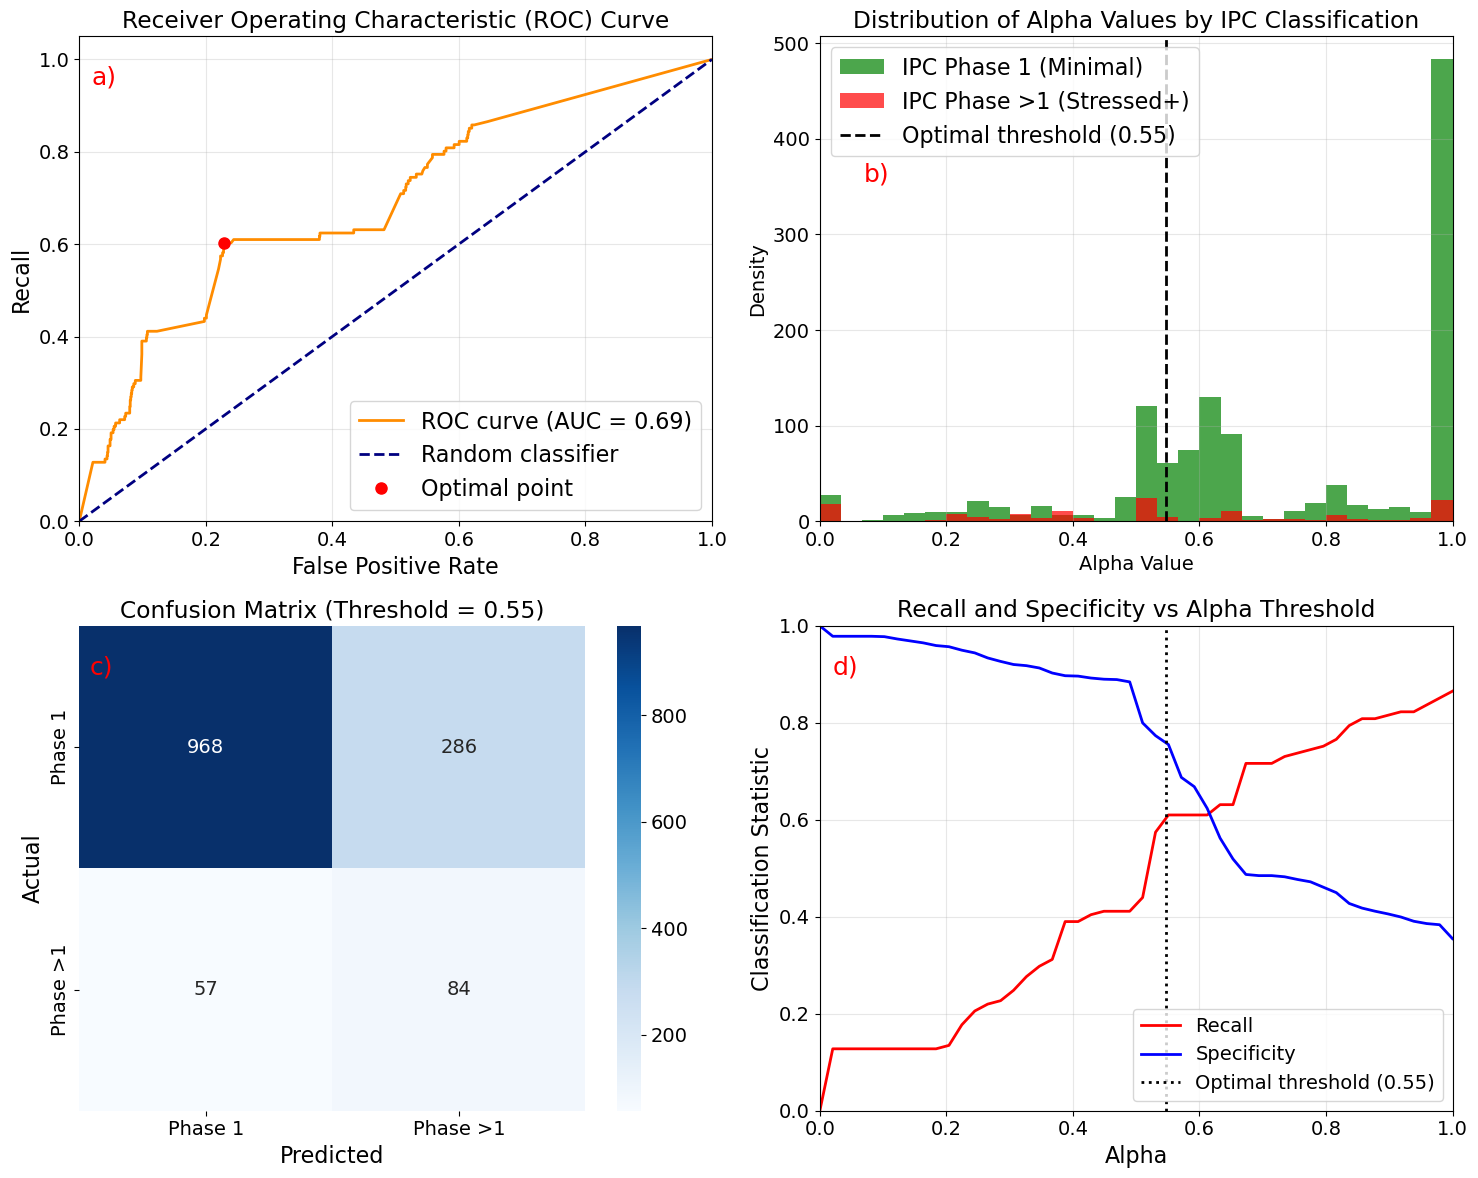


Performance at Optimal Threshold (0.55):
              precision    recall  f1-score   support

     Phase 1       0.94      0.77      0.85      1254
    Phase >1       0.23      0.60      0.33       141

    accuracy                           0.75      1395
   macro avg       0.59      0.68      0.59      1395
weighted avg       0.87      0.75      0.80      1395


Additional Metrics:
Accuracy: 0.754
Precision: 0.227
Recall (Sensitivity): 0.596
Specificity: 0.772
F1-Score: 0.329
Positive Predictive Value: 0.227
Negative Predictive Value: 0.944

Cross-tabulation at optimal threshold:
Predicted     0    1   All
Actual                    
0           968  286  1254
1            57   84   141
All        1025  370  1395


In [910]:

alpha_to_plot = sim_notrade_adm2_alpha_monthly_new
stock_to_plot = sim_notrade_adm2_calorie_stock_eom
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


fs_data_harmonized = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\HFID_hv1.csv")
country_fsdat = fs_data_harmonized[fs_data_harmonized['ADMIN0'] == target_nation_sim].copy()
#for window in np.arange(4,10):

sim_gravity_halfdensityadm2_alpha_smoothed =alpha_to_plot#apply_yearly_running_mean(sim_gravity_halfdensityadm2_alpha_monthly_new,window_months = 4)
regions_adm2_bf = adm_gdf[adm_gdf.COUNTRY == target_nation_sim][adm_col].unique()
#df_results = pd.DataFrame([])
target_cereals = target_cereals
for time in [4]:
    print(time)
    df_results = pd.DataFrame([])
    corrs = []
    sim_dfs = pd.DataFrame([])
    #national_max_yield = nation_hvstat[nation_hvstat["product"].isin(target_cereals)].groupby(["harvest_year","admin_2"])["yield"].mean().max()
    for region_idx, region_name in enumerate(regions_adm2_bf):
        # Create time index for simulation data
        sim_time_data = []
        #regional_max_yield = nation_hvstat[(nation_hvstat["product"].isin(target_cereals))&(nation_hvstat["admin_2"]==region_name)].groupby("harvest_year")["yield"].mean().max()  
        for year_idx, year in enumerate(regional_years[:]):
                #GDP = (gdp_data[(gdp_data["iso3"]==cc.convert("Burkina Faso", to="iso3", not_found=None))&(gdp_data.NAME_2==region_name)][str(year)].values - gdp_data[(gdp_data["iso3"]==cc.convert("Burkina Faso", to="iso3", not_found=None))&(gdp_data.NAME_2==region_name)][str(year-1)].values)/gdp_data[(gdp_data["iso3"]==cc.convert("Burkina Faso", to="iso3", not_found=None))&(gdp_data.NAME_2==region_name)][str(year-1)].values
                #print(GDP)
                #regional_mean_yield = nation_hvstat[(nation_hvstat["harvest_year"]== year)&(nation_hvstat["product"].isin(target_cereals))&(nation_hvstat["admin_2"]==region_name)]["yield"].mean()
                #yearly_max_yield = nation_hvstat[(nation_hvstat["harvest_year"]== year)&(nation_hvstat["product"].isin(target_cereals))].groupby("admin_2")["yield"].mean().max()
                for month in range(1, 13):
                    month_step = year_idx * 12 + month - 1
                    #if month_step < len(region_alpha_phases):
                    if stock_to_plot[month_step, region_idx] < 1e110:
                        if month_step >= time:
                            sim_time_data.append({
                                    'year_month': f'{year:04d}-{month:02d}',
                                    'region': region_name,
                                    'region_index': region_idx,
                                    'alpha_value': np.mean(sim_gravity_halfdensityadm2_alpha_smoothed[month_step:month_step+time, region_idx]),
                                    'year': year,
                                    'month': month,
                                    'stocks': np.mean(stock_to_plot[month_step:month_step+time, region_idx]),
                                    #'yield_gap_local': regional_mean_yield/regional_max_yield,
                                    #'yield_gap_national': regional_mean_yield/national_max_yield,
                                    #'yield_gap_yearly_national': regional_mean_yield/yearly_max_yield,
                                    #'GDP': GDP[0] if GDP.size > 0 else np.nan,
                                })
                        else: 
                            sim_time_data.append({
                                    'year_month': f'{year:04d}-{month:02d}',
                                    'region': region_name,
                                    'region_index': region_idx,
                                    'alpha_value': sim_gravity_halfdensityadm2_alpha_smoothed[month_step, region_idx],
                                    'year': year,
                                    'month': month,
                                    'stocks': np.mean(stock_to_plot[month_step:month_step+time, region_idx]),
                                })
        
        sim_df = pd.DataFrame(sim_time_data)
        sim_dfs = pd.concat([sim_dfs, sim_df])
        # Get IPC data for this region (match by admin2 name)
        fs_data_col = "ADMIN"+adm_col[-1]
        #ipc_region_data = country_fsdat[country_fsdat[fs_data_col] == region_name]["ipc_phase_fews"].groupby("ADMIN1").mean().reset_index().copy()
        if target_nation_sim == "Malawi":
            admin2_pop_weights = dict(zip(adm2_gdf[adm2_gdf.COUNTRY == target_nation_sim]['NAME_2'], 
                                    adm2_gdf[adm2_gdf.COUNTRY == target_nation_sim]['total_pop_count']))
            admin1_pop_weights = dict(zip(adm1_gdf[adm1_gdf.COUNTRY == target_nation_sim]['NAME_1'], 
                                    adm1_gdf[adm1_gdf.COUNTRY == target_nation_sim]['total_pop_count']))
            
            #country_fsdat['pop_weight_admin2'] = country_fsdat['ADMIN2'].map(admin2_pop_weights)
            #country_fsdat['pop_weight_admin1'] = country_fsdat['ADMIN1'].map(admin1_pop_weights)
            #country_fsdat["pop_weight_normalized"] = country_fsdat['pop_weight_admin2'] / country_fsdat['pop_weight_admin1']
            #country_fsdat["ipc_phase_fews_weighted"] = country_fsdat['ipc_phase_fews'] * country_fsdat['pop_weight_normalized']
            #country_fsdat.drop(columns=['ipc_phase_fews'],inplace=True)
            #country_fsdat.rename(columns={'ipc_phase_fews_weighted': 'ipc_phase_fews'}, inplace=True)
            ipc_region_data = country_fsdat[country_fsdat[fs_data_col] == region_name].groupby(["ADMIN1","year_month"])["ipc_phase_fews"].mean().reset_index().copy()
        else:
            ipc_region_data = country_fsdat[country_fsdat[fs_data_col] == region_name][["year_month", "ipc_phase_fews"]].copy()
        if not ipc_region_data.empty:
            # Merge simulation and IPC data
            merged = pd.merge(sim_df, ipc_region_data[['year_month', 'ipc_phase_fews']], 
                            on='year_month', how='inner')
            #merged = merged[merged['ha_fews']==0]  # Filter out rows with NaN IPC values
        df_results = pd.concat([df_results, merged], ignore_index=True)
    
    df_results.dropna(subset="ipc_phase_fews",inplace=True)
    #print(f"Processed region: {region_name}, Time window: {time}, Window size: {window}")
    #print(np.corrcoef(df_results.alpha_value,df_results.ipc_phase_fews)[0,1])
    if (time>3):
        max_corr = np.abs(np.corrcoef(df_results.alpha_value,df_results.ipc_phase_fews)[0,1])
        max_corr = np.corrcoef(df_results.alpha_value,df_results.ipc_phase_fews)[0,1]
        best_time = time
        df_results_best = df_results.copy()
    else:

        #print(f"Best window size: {best_window}, Best time: {best_time}, Max correlation: {max_corr:.3f}")
        if np.abs(np.corrcoef(df_results.alpha_value,df_results.ipc_phase_fews)[0,1])>np.abs(max_corr):
            max_corr = np.corrcoef(df_results.alpha_value,df_results.ipc_phase_fews)[0,1]
            best_time = time

    # Create binary IPC phases: 1 (minimal) vs >1 (stressed or worse)
    #df_results_best = df_results.copy()
    df_results_best_copy = df_results_best.copy()

    # Remove rows with very high stocks (outliers) if needed
    df_results_best_copy['ipc_binary'] =(df_results_best_copy['ipc_phase_fews'] > 1).astype(int)
    df_clean = df_results_best_copy#[df_results_best_copy['stocks'] < 1e11].copy()

    # Create ROC curve using alpha values as continuous predictor
    # We'll use 1 - alpha_value so that higher values indicate higher risk
    risk_score = 1 - df_clean['alpha_value']
    true_labels = df_clean['ipc_binary']

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, risk_score)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)


import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

import matplotlib.pyplot as plt

# Create binary IPC phases: 1 (minimal) vs >1 (stressed or worse)
#df_results_best_copy = df_results_best.copy()

# Remove rows with very high stocks (outliers) if needed
#df_results_best_copy['ipc_binary'] = (df_results_best_copy['ipc_phase_fews'] > 1).astype(int)
df_clean = df_results_best_copy#[df_results_best_copy['stocks'] < 1e11].copy()

# Create ROC curve using alpha values as continuous predictor
# We'll use 1 - alpha_value so that higher values indicate higher risk
risk_score = 1 - df_clean['alpha_value']
true_labels = (df_clean['ipc_binary'])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, risk_score)
roc_auc = auc(fpr, tpr)

# Find optimal threshold (Youden's J statistic)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_alpha_threshold = 1 - optimal_threshold
df_results_best_copy['alpha_binary'] = (df_results_best_copy['alpha_value'] < optimal_threshold).astype(int)
df_results_best_copy['ipc_binary'] = (df_results_best_copy['ipc_phase_fews'] > 1).astype(int)

print(f"\nROC Analysis:")
print(f"AUC: {roc_auc:.3f}")
print(f"Optimal threshold (risk score): {optimal_threshold:.3f}")
print(f"Optimal alpha threshold: {optimal_alpha_threshold:.3f}")
print(f"Sensitivity at optimal point: {tpr[optimal_idx]:.3f}")
print(f"Specificity at optimal point: {1-fpr[optimal_idx]:.3f}")

# Create the ROC plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
plt.rcParams.update({'font.size': 14})
default_fontsize = 16
# Plot 1: ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
ax1.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8, label=f'Optimal point')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate',fontsize=default_fontsize)
ax1.set_ylabel('Recall',fontsize=default_fontsize)
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right",fontsize=default_fontsize)
ax1.grid(True, alpha=0.3)
ax1.text(0.02, 0.9, "a)",fontsize=18,color="red",transform=ax1.transAxes)
# Plot 2: Distribution of alpha values by IPC class
test= ax2.hist(df_clean[df_clean['ipc_binary'] == 0]['alpha_value'], 
        bins=30, alpha=0.7, label='IPC Phase 1 (Minimal)', color='green', density=False)
ax2.hist(df_clean[df_clean['ipc_binary'] == 1]['alpha_value'], 
        bins=30, alpha=0.7, label='IPC Phase >1 (Stressed+)', color='red', density=False)
ax2.axvline(optimal_alpha_threshold, color='black', linestyle='--', linewidth=2, 
            label=f'Optimal threshold ({optimal_alpha_threshold:.2f})')
ax2.set_xlabel('Alpha Value')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of Alpha Values by IPC Classification')

ax2.legend(fontsize=default_fontsize)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0.,1)
ax2.text(0.07, 0.7, "b)",fontsize=18,color="red",transform=ax2.transAxes)

# Plot 3: Confusion Matrix at optimal threshold
y_pred_optimal = (df_clean['alpha_value'] < optimal_alpha_threshold).astype(int)
cm = confusion_matrix(df_clean['ipc_binary'], y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_xlabel('Predicted',fontsize=default_fontsize)
ax3.set_ylabel('Actual',fontsize= default_fontsize)
ax3.set_title(f'Confusion Matrix (Threshold = {optimal_alpha_threshold:.2f})')
ax3.set_xticklabels(['Phase 1', 'Phase >1'])
ax3.set_yticklabels(['Phase 1', 'Phase >1'])
ax3.text(0.02, 0.9, "c)",fontsize=18,color="red",transform=ax3.transAxes)
# Plot 4: Threshold analysis
# Calculate sensitivity and specificity for different thresholds
alpha_thresholds = np.linspace(0.0, 1.0, 50)
sensitivities = []
specificities = []

for thresh in alpha_thresholds:
    y_pred = (df_clean['alpha_value'] < thresh).astype(int)
    cm_temp = confusion_matrix(df_clean['ipc_binary'], y_pred)
    if cm_temp.shape == (2, 2):
        tn, fp, fn, tp = cm_temp.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    else:
        sensitivity = 0
        specificity = 1 if np.all(y_pred == 0) else 0
    sensitivities.append(sensitivity)
    specificities.append(specificity)

ax4.plot(alpha_thresholds, sensitivities, label='Recall', color='red', linewidth=2)
ax4.plot(alpha_thresholds, specificities, label='Specificity', color='blue', linewidth=2)
ax4.axvline(optimal_alpha_threshold, color='black', linestyle=':', linewidth=2, 
            label=f'Optimal threshold ({optimal_alpha_threshold:.2f})')
ax4.set_xlabel('Alpha',fontsize=default_fontsize)
ax4.set_ylabel('Classification Statistic',fontsize= default_fontsize)
ax4.set_title('Recall and Specificity vs Alpha Threshold')
ax4.set_ylim(0,1)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0.0, 1)
ax4.text(0.02, 0.9, "d)",fontsize=18,color="red",transform=ax4.transAxes)
plt.tight_layout()
plt.show()

# Performance metrics at optimal threshold
print(f"\nPerformance at Optimal Threshold ({optimal_alpha_threshold:.2f}):")
print("=" * 50)
print(classification_report(df_clean['ipc_binary'], y_pred_optimal, 
                        target_names=['Phase 1', 'Phase >1']))

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f"\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"Specificity: {tn/(tn+fp):.3f}")
print(f"F1-Score: {f1_score:.3f}")
print(f"Positive Predictive Value: {precision:.3f}")
print(f"Negative Predictive Value: {tn/(tn+fn):.3f}")

# Cross-tabulation
print(f"\nCross-tabulation at optimal threshold:")
ct = pd.crosstab(df_clean['ipc_binary'], y_pred_optimal, 
                rownames=['Actual'], colnames=['Predicted'], margins=True)
print(ct)



### National IPC Comparison

Aggregating IPC data to national level...
1
Created national IPC data with 97 time points
Aggregating alpha data to national level for Malawi...
Created interpolated alpha data with 360 monthly points

Correlation Results for Malawi:
Number of matched data points: 96
Time period: 2011-2023
Pearson correlation (Alpha vs IPC): 0.1670
Spearman correlation (Alpha vs IPC): 0.1101
RMSE (Alpha predicting IPC): 0.3573

Summary Statistics:
Alpha - Mean: 0.287, Std: 0.278
IPC - Mean: 0.089, Std: 0.166

Inverted Alpha Analysis:
Correlation (Inverted Alpha vs IPC): -0.1670
(Higher values indicate better alignment - both high values = food insecurity)
Randomized monthly IPC correlation coefficients:
-0.001007195189560039 0.17430138575022797
monthly-corr-coef forMalawi:
0.16697863240636118
Randomized yearly IPC correlation coefficients:
-0.005602558164509698 0.5216329048652681
yearly-corr-coef forMalawi:
-0.013906476023481313


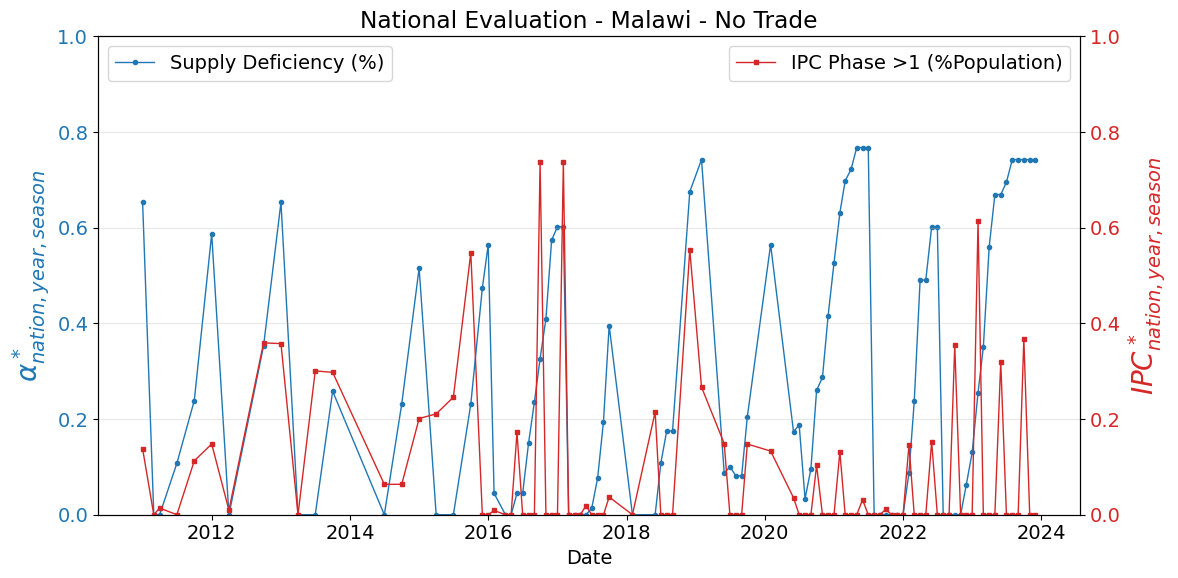

In [889]:
import pandas as pd
import numpy as np
from scipy import interpolate
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Create figure with dual y-axes
fig, ax = plt.subplots(nrows=1,figsize=(12, 6))
#target_nation = "Burkina Faso"
for target_nation in [target_nation_sim]:
    # 1. Aggregate IPC data to national level using ADM2 population weights
    print("Aggregating IPC data to national level...")
    #for target_nation in ["Burkina Faso","Malawi"]:
    # Get target nation ADM2 data
    if target_nation == "Malawi":
        r = 1
        target_adm2_data = adm1_gdf[adm1_gdf.COUNTRY == target_nation].copy()
        adm_col = "NAME_1"
        adm_col_fs = "ADMIN1"
    if target_nation == "Burkina Faso":
        r = 0
        target_adm2_data = adm2_gdf[adm2_gdf.COUNTRY == target_nation].copy()
        adm_col = "NAME_2"
        adm_col_fs = "ADMIN2"
    print(r)
    if not target_adm2_data.empty:
        # Calculate total population for normalization
        total_national_pop = target_adm2_data['total_pop_count'].sum()
        
        # Get food security data for target nation
        target_fs_data = fs_data_harmonized[fs_data_harmonized.ADMIN0 == target_nation].copy()
        
        if not target_fs_data.empty:
            # Create mapping from ADM2 names to population weights
            adm2_pop_weights = dict(zip(target_adm2_data[adm_col], target_adm2_data['total_pop_count']))
            
            # Add population weights to food security data
            target_fs_data['pop_weight'] = target_fs_data[adm_col_fs].map(adm2_pop_weights)
            target_fs_data['ipc_phase_binary'] = target_fs_data['ipc_phase_fews'].apply(lambda x: 1 if x > 1 else 0)
            # Filter out rows without population weights or IPC data
            weighted_fs_data = target_fs_data.dropna(subset=['pop_weight', 'ipc_phase_binary'])
            
            if not weighted_fs_data.empty:
                # Calculate population-weighted national IPC averages by year-month
                national_ipc = weighted_fs_data.groupby('year_month').apply(
                    lambda x: pd.Series({
                        'ipc_national_weighted': (x['ipc_phase_binary'] * x['pop_weight']).sum() / x['pop_weight'].sum(),
                        'total_weight': x['pop_weight'].sum(),
                        'num_regions': len(x)
                    })
                ).reset_index()
                
                # Convert year_month to datetime for easier interpolation
                national_ipc['datetime'] = pd.to_datetime(national_ipc['year_month'])
                national_ipc['year'] = national_ipc['datetime'].dt.year
                national_ipc['month'] = national_ipc['datetime'].dt.month
                
                print(f"Created national IPC data with {len(national_ipc)} time points")
                
            else:
                print("No weighted food security data available after filtering")
                national_ipc = pd.DataFrame()
        else:
            print(f"No food security data found for {target_nation}")
            national_ipc = pd.DataFrame()
    else:
        print(f"No ADM2 population data found for {target_nation}")
        national_ipc = pd.DataFrame()

    # 2. transform alpha data to same resolution

    # 2. Transform alpha data to national level using weighted average
    print(f"Aggregating alpha data to national level for {target_nation}...")

    if not national_ipc.empty:
        # Get alpha data for the target nation
        if target_nation == "Malawi":
            alpha_data = sim_notrade_adm2_alpha_monthly_new#.apply(lambda x: 1 if x > optimal_alpha_threshold else 0)
            regional_names = np.sort(adm1_gdf[adm1_gdf.COUNTRY == target_nation].NAME_1.unique())
            pop_weights = adm1_gdf[adm1_gdf.COUNTRY == target_nation].set_index('NAME_1').loc[regional_names]['total_pop_count'].values
        else:  # Burkina Faso
            alpha_data = sim_notrade_adm2_alpha_monthly_new#.apply(lambda x: 1 if x > optimal_alpha_threshold else 0)
            regional_names = np.sort(adm2_gdf[adm2_gdf.COUNTRY == target_nation].NAME_2.unique())
            pop_weights = adm2_gdf[adm2_gdf.COUNTRY == target_nation].set_index('NAME_2').loc[regional_names]['total_pop_count'].values
        

        # 1. Apply a 4-month forward-looking mean to the regional alpha data
        raw_alpha_data = alpha_data
        num_months, num_regions = raw_alpha_data.shape
        alpha_smoothed = np.zeros_like(raw_alpha_data)
        # Calculate the forward-looking mean for each time step
        for t in range(num_months):
            end_window = min(t + 4, num_months)
            if t < end_window: # Ensure the slice is not empty
                alpha_smoothed[t, :] = np.mean(raw_alpha_data[t:end_window, :], axis=0)
            else: # Handle the very end of the array
                alpha_smoothed[t, :] = raw_alpha_data[t, :]
        # 2. Binarize the smoothed alpha data using the optimal threshold
        # A lower alpha value indicates a higher risk of food insecurity
        alpha_binary_regional = (alpha_smoothed < optimal_alpha_threshold).astype(int)

        # 3. Calculate the national average of the binary classifier using population weights

        # Normalize population weights
        pop_weights_normalized = pop_weights / pop_weights.sum()

        # Calculate the national average, which represents the proportion of the population in crisis
        national_alpha_binary_avg = np.average(alpha_binary_regional, axis=1, weights=pop_weights_normalized)

        # Create monthly interpolated alpha data
        alpha_monthly_list = []
        for i, year in enumerate(regional_years):
            for j,month in enumerate(range(1, 13)):
                # Get the alpha value for this year
                year_idx = i * 12 + j
                alpha_value = national_alpha_binary_avg[year_idx]
                # Create 12 monthly records for each year (constant alpha assumption)
                alpha_monthly_list.append({
                    'year': year,
                    'month': month,
                    'datetime': pd.Timestamp(year=year, month=month, day=15),  # Mid-month
                    'alpha_national_interpolated': alpha_value
                })

        alpha_monthly = pd.DataFrame(alpha_monthly_list)
        print(f"Created interpolated alpha data with {len(alpha_monthly)} monthly points")

        merged_data = pd.merge(national_ipc, alpha_monthly, on=['year', 'month'], how='inner')

        
    if not merged_data.empty:
            # Calculate correlations
            correlation_pearson = merged_data['alpha_national_interpolated'].corr(merged_data['ipc_national_weighted'])
            correlation_spearman = merged_data['alpha_national_interpolated'].corr(merged_data['ipc_national_weighted'], method='spearman')
            
            # Calculate RMSE (alpha as predictor of IPC)
            rmse = np.sqrt(mean_squared_error(merged_data['ipc_national_weighted'], merged_data['alpha_national_interpolated']))
            
            print(f"\nCorrelation Results for {target_nation}:")
            print(f"{'='*50}")
            print(f"Number of matched data points: {len(merged_data)}")
            print(f"Time period: {merged_data['year'].min()}-{merged_data['year'].max()}")
            print(f"Pearson correlation (Alpha vs IPC): {correlation_pearson:.4f}")
            print(f"Spearman correlation (Alpha vs IPC): {correlation_spearman:.4f}")
            print(f"RMSE (Alpha predicting IPC): {rmse:.4f}")
            
            # Summary statistics
            print(f"\nSummary Statistics:")
            print(f"Alpha - Mean: {merged_data['alpha_national_interpolated'].mean():.3f}, Std: {merged_data['alpha_national_interpolated'].std():.3f}")
            print(f"IPC - Mean: {merged_data['ipc_national_weighted'].mean():.3f}, Std: {merged_data['ipc_national_weighted'].std():.3f}")
            
            # Additional analysis: Inverse correlation (higher alpha should mean lower IPC)
            # Since Alpha=1 means good food security and IPC=1 means minimal food insecurity
            # We expect a negative correlation
            alpha_inverted = 1 - merged_data['alpha_national_interpolated'] + 1  # Convert to similar scale as IPC
            correlation_inverted = alpha_inverted.corr(merged_data['ipc_national_weighted'])
            
            print(f"\nInverted Alpha Analysis:")
            print(f"Correlation (Inverted Alpha vs IPC): {correlation_inverted:.4f}")
            print(f"(Higher values indicate better alignment - both high values = food insecurity)")
        
    else:
        print("No overlapping data found between alpha and IPC time series")

    import pandas as pd

    import matplotlib.pyplot as plt
    # Plot alpha (food sufficiency) on left y-axis
    color = 'tab:blue'
    ax.set_xlabel('Date')
    ax.set_ylabel(r'$\alpha^*_{nation,year,season}} $', color=color,fontsize=20)

    year_alpha = merged_data.groupby("year")['alpha_national_interpolated'].mean()
    month_alpha = merged_data.groupby("year_month")['alpha_national_interpolated'].mean()
    ax.plot(pd.to_datetime(month_alpha.index).values,month_alpha.values, 
            label=r'Supply Deficiency (%)', color=color, marker='o', linewidth=1, markersize=3)
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_ylim(0, 1)

    # Create second y-axis for IPC
    ax2 = ax.twinx()
    color = 'tab:red'
    ax2.set_ylabel(r'$IPC^*_{nation,year,season}$', color=color,fontsize=20)

    year_ipc = merged_data.groupby("year")['ipc_national_weighted'].mean()
    month_ipc = merged_data.groupby("year_month")['ipc_national_weighted'].mean()
    ax2.plot(pd.to_datetime(month_ipc.index).values, month_ipc.values,
            label='IPC Phase >1 (%Population)', color=color, marker='s', linewidth=1, markersize=3)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 1)

    # Add title and format
    plt.title(f'National Evaluation - {target_nation} - No Trade')

    # Add legends
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    corrs_month = []
    for i in range(5000):
        ipc_copy = np.copy(month_ipc.values)
        np.random.shuffle(ipc_copy)
        corrs_month.append(np.corrcoef(month_alpha.values, ipc_copy)[0, 1])
    corrs_year = []
    for i in range(5000):
        ipc_copy = np.copy(year_ipc.values)
        np.random.shuffle(ipc_copy)
        corrs_year.append(np.corrcoef(year_alpha.values, ipc_copy)[0, 1])
    print("Randomized monthly IPC correlation coefficients:")
    print(np.mean(corrs_month), np.quantile(corrs_month,0.95))
    print("monthly-corr-coef for" + target_nation + ":")
    print(np.corrcoef(month_alpha.values, month_ipc.values)[0, 1])
    print("Randomized yearly IPC correlation coefficients:")
    print(np.mean(corrs_year), np.quantile(corrs_year,0.95))
    print("yearly-corr-coef for" + target_nation + ":")
    print(np.corrcoef(year_alpha.values, year_ipc.values)[0, 1])
    fig.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()



In [628]:
plt.rcParams['font.size'] = 14

In [621]:
alpha_data.shape

(336, 45)